# 학습 관련 기술들

이번 장에서 알아볼 내용
- 최적화 방법
- 가중치 매개변수 초깃값 (전에는 random으로 설정)
- 하이퍼파라미터 설정 방법 (node, lr, batch size....)
- 오버피팅 방지 (가중치 감소, 드랍아웃 등 정규화 방법)
- 배치 정규화

In [1]:
# 라이브러리
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = '/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)

# 매개변수 갱신

매개변수의 최적값을 찾는 이런 과정을 최적화(Optimization)라고 한다.

최적의 매개변수를 찾을 단서로 매개변수의 기울기(1.수치미분 2.오차역전파법)을 앞서 살펴봤음

GD의 수식

$W \leftarrow W - \eta\frac{\partial{L}}{\partial{W}}$

아래와 같이 구현하면 SGD의 인스턴스에 매개변수와 기울기 정보를 전달하면 매개변수가 update 

참고내용 Lasagne 프레임워크의 최적화 기법들 

https://github.com/Lasagne/Lasagne/blob/master/lasagne/updates.py

In [3]:
# Gradient Descent 구현

class SGD(object):
    def __init__(self, lr = 0.01):
        self.lr = lr  # 인스턴스 변수로 learning rate 

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SGD의 문제점

방향에 따라 기울기가 달라지는 함수에서는 탐색 경로가 비효율적이다.

따라서 개선된 최적화 기법을 살펴보자:
- 모멘텀(Momentum)
- AdaGrad(Adaptive Gradient)
- Adam


In [4]:
# 모멘텀
class Momentum(object):
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr # learning rate 
        self.momentum = momentum # 일반적으로 0.9 (따라서 default값 0.9)
        self.v = None # V(0) = 0

    def update(self, params, grads):
        if self.v is None: # 처음 갱신
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]     

In [5]:
# AdaGrad
class Adagrad(object):
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None: # 처음 갱신
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [6]:
W1 = np.array([[1, 2], [3, 4]])
W2 = np.array([[2, 4], [6, 8]])
print(W1 * W2) # element wise

[[ 2  8]
 [18 32]]


RMSProp은

Adagrad의 식에서 $h$ 부분이 다름
$h_i \leftarrow ph + (1-p)\frac{\partial{L}}{\partial{W}}\odot\frac{\partial{L}}{\partial{W}}$

$p$ 값이 작을수록 최신 기울기를 많이 반영

In [7]:
# RMSProp
class RMSProp(object):
    def __init__(self, lr = 0.01, p = 0.9):
        self.lr = lr
        self.p = p # 추가
        self.h = None

    def update(self, params, grads):
        if self.h is None: # 처음 갱신
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] = self.p * self.h[key] + (1 - self.p) * (grads[key] * grads[key]) # 식 반영
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

Adam ( https://arxiv.org/pdf/1412.6980v8.pdf )

AdaGrad + RMSProp 각각의 장점을 이용

성능은 아래와 같이 대부분의 경우에서 가장 좋음

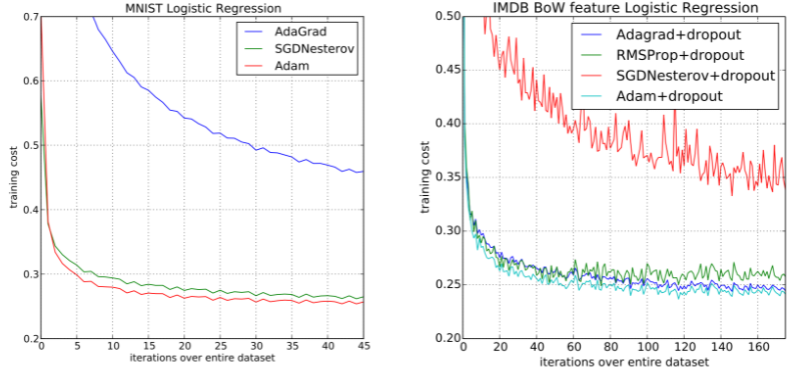

In [8]:
class Adam(object):
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999): # 논문에서 가장 좋은 성능을 
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None: # 처음 갱신
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1

        # learning rate도 beta를 통해 조정하면 성능이 더 좋아진다.
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key] # Momentum
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2) # AdaGrad / RMSProp

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # AdaGrad / RMSProp

# 가중치의 초깃값

앞에서 가중치 초깃값은 랜덤으로 설정했었다.

하지만 가중치 초깃값도 신경망 학습에 영향을 끼치므로 어떤 식으로 설정하면 좋을지 확인

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

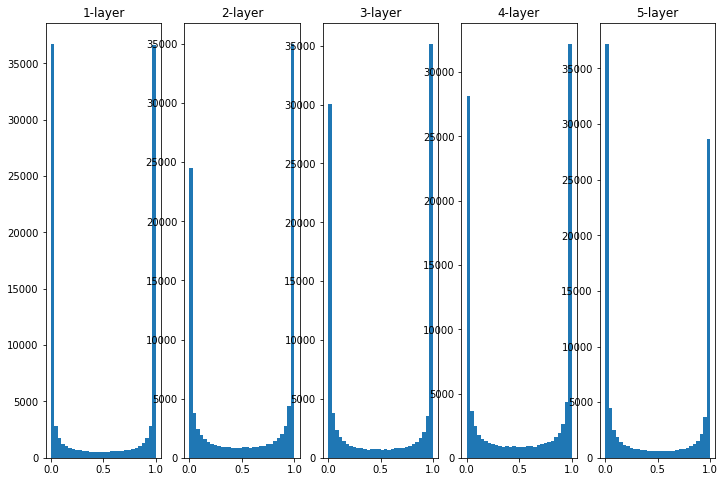

In [10]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

이번에는 가중치를 표준편차가 0.01인 정규분포로 바꿔서 실험

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01 # 표준편차 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

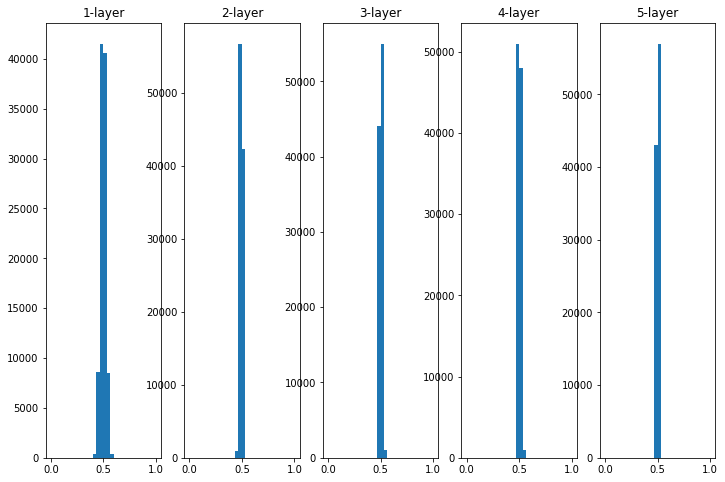

In [13]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

Xavier 초깃값을 사용해보자

Xavier 초깃값은 초깃값의 표준편차가 $\frac{1}{\sqrt{n}}$ 인 정규분포로 초기화

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

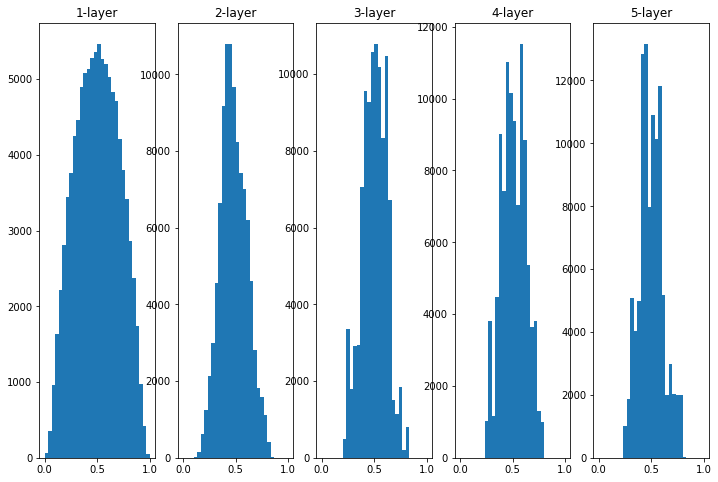

In [15]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()